# Should I stay or should I go?
## What's the probability to get a new first down?

At Kaggle I found a data set with every play of the NFL season 2015. https://www.kaggle.com/maxhorowitz/nflplaybyplay2015

With these data I try to answer the following questions:

* Can I predict if a team will reach a new first down in the next play given quarter, time left in quarter, current down, yards to go, position on field?
* Can I give a probability for reaching the first down?
* Is there a difference between the teams on offense?

Next steps:

* Combining the play by play data to data about a drive: What's the possibily to score a touchdown / field goal given the starting position on the field?
* Again: Is there a preferred QB for 2-minute drives?
* How does the data change from season to season?


In [1]:
# Import all the packages required
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score, mean_squared_error, f1_score

In [2]:
# Read the data and show the first rows
data = pd.read_csv("data/NFLPlaybyPlay2015.csv", low_memory=False)
print(data.shape)
data.head(30)

(46129, 66)


,Unnamed: 0,Date,GameID,Drive,qtr,down,time,TimeUnder,TimeSecs,PlayTimeDiff,SideofField,yrdln,yrdline100,ydstogo,ydsnet,GoalToGo,FirstDown,posteam,DefensiveTeam,desc,PlayAttempted,Yards.Gained,sp,Touchdown,ExPointResult,TwoPointConv,DefTwoPoint,Safety,PuntResult,PlayType,Passer,PassAttempt,PassOutcome,PassLength,PassLocation,InterceptionThrown,Interceptor,Rusher,RushAttempt,RunLocation,RunGap,Receiver,Reception,ReturnResult,Returner,BlockingPlayer,Tackler1,Tackler2,FieldGoalResult,FieldGoalDistance,Fumble,RecFumbTeam,RecFumbPlayer,Sack,Challenge.Replay,ChalReplayResult,Accepted.Penalty,PenalizedTeam,PenaltyType,PenalizedPlayer,Penalty.Yards,PosTeamScore,DefTeamScore,ScoreDiff,AbsScoreDiff,Season
0,36,2015-09-10,2015091000,1,1,NaN,15:00,15,3600.0,0.0,NE,35.0,35.0,0,0,0.0,NaN,PIT,NE,S.Gostkowski kicks 65 yards from NE 35 to end ...,1,0,0,0,NaN,NaN,NaN,0,NaN,Kickoff,NaN,0,NaN,NaN,NaN,0,NaN,NaN,0,NaN,NaN,NaN,0,Touchback,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0,0,NaN,0,NaN,NaN,NaN,0,0.0,0.0,0.0,0.0,2015
1,51,2015-09-10,2015091000,1,1,1.0,15:00,15,3600.0,0.0,PIT,20.0,80.0,10,18,0.0,1.0,PIT,NE,(15:00) De.Williams right tackle to PIT 38 for...,1,18,0,0,NaN,NaN,NaN,0,NaN,Run,NaN,0,NaN,NaN,NaN,0,NaN,D.Hightower,1,right,tackle,NaN,0,NaN,NaN,NaN,D.Hightower,NaN,NaN,NaN,0,NaN,NaN,0,0,NaN,0,NaN,NaN,NaN,0,0.0,0.0,0.0,0.0,2015
2,72,2015-09-10,2015091000,1,1,1.0,14:21,15,3561.0,39.0,PIT,38.0,62.0,10,31,0.0,0.0,PIT,NE,(14:21) B.Roethlisberger pass short right to A...,1,9,0,0,NaN,NaN,NaN,0,NaN,Pass,B.Roethlisberger,1,Complete,Short,right,0,NaN,NaN,0,NaN,NaN,A.Brown,1,NaN,NaN,NaN,D.Hightower,NaN,NaN,NaN,0,NaN,NaN,0,0,NaN,0,NaN,NaN,NaN,0,0.0,0.0,0.0,0.0,2015
3,101,2015-09-10,2015091000,1,1,2.0,14:04,15,3544.0,17.0,PIT,47.0,53.0,1,31,0.0,1.0,PIT,NE,(14:04) De.Williams right guard to NE 49 for 4...,1,4,0,0,NaN,NaN,NaN,0,NaN,Run,NaN,0,NaN,NaN,NaN,0,NaN,J.Collins,1,right,guard,NaN,0,NaN,NaN,NaN,J.Collins,M.Brown,NaN,NaN,0,NaN,NaN,0,0,NaN,0,NaN,NaN,NaN,0,0.0,0.0,0.0,0.0,2015
4,122,2015-09-10,2015091000,1,1,1.0,13:26,14,3506.0,38.0,NE,49.0,49.0,10,45,0.0,1.0,PIT,NE,(13:26) B.Roethlisberger pass short right to H...,1,14,0,0,NaN,NaN,NaN,0,NaN,Pass,B.Roethlisberger,1,Complete,Short,right,0,NaN,NaN,0,NaN,NaN,H.Miller,1,NaN,NaN,NaN,J.Mayo,NaN,NaN,NaN,0,NaN,NaN,0,0,NaN,0,NaN,NaN,NaN,0,0.0,0.0,0.0,0.0,2015
5,159,2015-09-10,2015091000,1,1,1.0,12:42,13,3462.0,44.0,NE,35.0,35.0,10,56,0.0,1.0,PIT,NE,(12:42) (Shotgun) De.Williams right guard to N...,1,11,0,0,NaN,NaN,NaN,0,NaN,Run,NaN,0,NaN,NaN,NaN,0,NaN,J.Collins,1,right,guard,NaN,0,NaN,NaN,NaN,J.Collins,NaN,NaN,NaN,0,NaN,NaN,0,0,NaN,0,NaN,NaN,NaN,0,0.0,0.0,0.0,0.0,2015
6,180,2015-09-10,2015091000,1,1,1.0,12:05,13,3425.0,37.0,NE,24.0,24.0,10,48,0.0,0.0,PIT,NE,(12:05) A.Brown sacked at NE 32 for -8 yards (...,1,-8,0,0,NaN,NaN,NaN,0,NaN,Sack,NaN,0,NaN,NaN,NaN,0,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,M.Brown,NaN,NaN,NaN,0,NaN,NaN,1,0,NaN,0,NaN,NaN,NaN,0,0.0,0.0,0.0,0.0,2015
7,199,2015-09-10,2015091000,1,1,2.0,11:20,12,3380.0,45.0,NE,32.0,32.0,18,54,0.0,0.0,PIT,NE,(11:20) (Shotgun) De.Williams right end pushed...,1,4,0,0,NaN,NaN,NaN,0,NaN,No Play,NaN,0,NaN,NaN,NaN,0,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,D.Hightower,NaN,NaN,NaN,0,NaN,NaN,0,0,NaN,1,PIT,NaN,M.Gilbert,10,0.0,0.0,0.0,0.0,2015
8,236,2015-09-10,2015091000,1,1,2.0,10:53,11,3353.0,27.0,NE,42.0,42.0,28,54,0.0,0.0,PIT,NE,(10:53) W.Johnson right guard to NE 36 for 6 y...,1,6,0,0,NaN,NaN,NaN,0,NaN,Run,NaN,0,NaN,NaN,NaN,0,NaN,W.Johnson,1,right,guard,NaN,0,NaN,NaN,NaN,R.Ninkovich,NaN,NaN,NaN,0,NaN,NaN,0,0,NaN,0,NaN,NaN,NaN,0,0.0,0.0,0.0,0.0,2015
9,261,2015-09-10,2015091000,1,1,3.0,10:28,11,3328.0,25.0,NE,36.0,36.0,22,54,0.0,0.0,PIT,NE,(10:28) (Shotgun) B.Roethlisberger pass short ...,1,10,0,0,NaN,NaN,NaN,0,NaN,Pass,B.Roethlisberger,1,Complete,Short,right,0,NaN,NaN,0,NaN,NaN,H.Miller,1,NaN,NaN,NaN,P.Chung,M.Butler,NaN,NaN,0,NaN,NaN,0,0,NaN,0,NaN,NaN,NaN,0,0.0,0.0,0.0,0.0,2015


In [3]:
# Select only the columns we're interested in. 'FirstDown' is the column we want to predict.
data_small = data[['qtr', 'down', 'TimeSecs', 'yrdline100', 'ydstogo', 'PlayType', 'FirstDown']].copy()
data_small.head(10)

,qtr,down,TimeSecs,yrdline100,ydstogo,PlayType,FirstDown
0,1,NaN,3600.0,35.0,0,Kickoff,NaN
1,1,1.0,3600.0,80.0,10,Run,1.0
2,1,1.0,3561.0,62.0,10,Pass,0.0
3,1,2.0,3544.0,53.0,1,Run,1.0
4,1,1.0,3506.0,49.0,10,Pass,1.0
5,1,1.0,3462.0,35.0,10,Run,1.0
6,1,1.0,3425.0,24.0,10,Sack,0.0
7,1,2.0,3380.0,32.0,18,No Play,0.0
8,1,2.0,3353.0,42.0,28,Run,0.0
9,1,3.0,3328.0,36.0,22,Pass,0.0


In [4]:
# As we can see there are some NaN-values. 
# So let's check them
data_small.isna().mean()

qtr           0.000000
down          0.154415
TimeSecs      0.000585
yrdline100    0.002341
ydstogo       0.000000
PlayType      0.000000
FirstDown     0.071929
dtype: float64

In [5]:
# A lot of NaNs in column 'down'.  
# Let's look at them
data_small[data_small['down'].isna()].head(20)

,qtr,down,TimeSecs,yrdline100,ydstogo,PlayType,FirstDown
0,1,NaN,3600.0,35.0,0,Kickoff,NaN
32,1,NaN,2700.0,19.0,0,Quarter End,0.0
41,2,NaN,2471.0,15.0,0,Extra Point,0.0
42,2,NaN,2471.0,35.0,0,Kickoff,NaN
59,2,NaN,2041.0,15.0,0,Extra Point,0.0
60,2,NaN,2041.0,35.0,0,Kickoff,NaN
65,2,NaN,1920.0,21.0,0,Two Minute Warning,NaN
69,2,NaN,1848.0,35.0,0,Timeout,0.0
71,2,NaN,1843.0,35.0,0,Timeout,NaN
74,2,NaN,1813.0,26.0,0,Timeout,0.0


The rows with down == NaN are unusual plays such as kickoff or PAT and timeouts or the ends of a quarter. So we can ignore them.

In [6]:
# Drop rows with down == NaA
data_small.dropna(subset=['down'], axis=0, inplace=True)

In [7]:
data_small.isna().mean()


qtr           0.0
down          0.0
TimeSecs      0.0
yrdline100    0.0
ydstogo       0.0
PlayType      0.0
FirstDown     0.0
dtype: float64

Great! All NaNs removed!

### Check the distribution of FirstDown

In [8]:
data_small['FirstDown'].value_counts()

0.0    26621
1.0    12385
Name: FirstDown, dtype: int64

#### Define function for upsampling to get 50:50 data

There is an imbalance 2:1 in favor to "no first down". 

So let's build a function to upsample the data, so both classes are even distributed.

In [9]:
def upsample_data(data):
    """
    Upsample data with FirstDown == 1
    
    Arguments:
    data: DataFrame
    
    Return Upsampled DataFrame
    """
    
    # Get counts for both values of FirstDown
    class_0, class_1 = data['FirstDown'].value_counts()

    # Split data
    data_class_0 = data[data['FirstDown'] == 0]
    data_class_1 = data[data['FirstDown'] == 1]    
    
    # Resample
    data_class_1_over = data_class_1.sample(class_0, replace=True)
    
    # Combine 
    data_over = pd.concat([data_class_0, data_class_1_over], axis=0)
    
    return data_over
    

In [10]:
data_small_upsampled = upsample_data(data_small)
data_small_upsampled['FirstDown'].value_counts()

1.0    26621
0.0    26621
Name: FirstDown, dtype: int64

## Prepare for Prediction
So let's split our data into a training and testing set.

In [11]:
X = data_small_upsampled[['qtr', 'down', 'TimeSecs', 'yrdline100', 'ydstogo']]
y = data_small_upsampled['FirstDown']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Using a simple Decision Tree as model.

In [12]:
# Get a model and train it
mdl = DecisionTreeClassifier()
mdl.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

How's the model doing on the training set?

In [13]:
y_pred = mdl.predict(X_train)
acc = accuracy_score(y_train, y_pred)
f1 = f1_score(y_train, y_pred)
print("The accuracy on the training data was {}.".format(acc))
print("The f1_score on the training data was {}.".format(f1))

The accuracy on the training data was 0.9917862749495403.
The f1_score on the training data was 0.9918007555617742.


Wow, that's great!
But what about the testing data?


In [14]:
y_pred = mdl.predict(X_test)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print("The accuracy on the testing data was {}.".format(acc))
print("The f1_score on the testing data was {}.".format(f1))

The accuracy on the testing data was 0.7914627205463859.
The f1_score on the testing data was 0.8047324664250692.


Okay, 79% accuracy that's not bad. But we can see the model did overfitting.
Let's try another model.

First we'll define a function we can pass the data and the model.

In [15]:
def score_by_model(data, model):
    """
    Split data and do a prediction with model. Than print out the accuracy on training and testing data.
    
    Arguments:
    data - DataFrame with the data. The last column contains the data which should be predicted.
    model - A classification model which is used for the prediction.
    
    Result: 
    returns the fitted model
    """
    
    # Upsample data
    data = upsample_data(data)
    
    # Get X and y from the data
    X = data.iloc[:, :-1]
    y = data[data.columns[-1]]
    
    # Split the data in training and testing data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Accuracy on training data
    y_pred = model.predict(X_train)
    acc = accuracy_score(y_train, y_pred)
    f1 = f1_score(y_train, y_pred)
    print("The accuracy on the training data was {}.".format(acc))
    print("The f1_score on the training data was {}.".format(f1))
    
    # Accuracy on testing dat
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)    
    print("The accuracy on the testing data was {}.".format(acc))
    print("The f1_score on the testing data was {}.".format(f1))
    
    return model

In [16]:
# Test the function with DecisionTreeClassifier
mdl = DecisionTreeClassifier()

# Drop column 'PlayType'
data_to_train = data_small.drop(columns=['PlayType'])

mdl_decision_tree = score_by_model(data_to_train, mdl)

The accuracy on the training data was 0.9917302085669433.
The f1_score on the training data was 0.991719763101019.
The accuracy on the testing data was 0.7931132612407513.
The f1_score on the testing data was 0.8066797851406691.


In [17]:
# Test the function with RandomForrest
mdl = RandomForestClassifier(n_estimators=20)

# Drop column 'PlayType'
data_to_train = data_small.drop(columns=['PlayType'])

mdl_random_forrest = score_by_model(data_to_train, mdl)

The accuracy on the training data was 0.9878896613590491.
The f1_score on the training data was 0.9878740245887835.
The accuracy on the testing data was 0.8149686966420034.
The f1_score on the testing data was 0.8229399270192256.


Better, but still overfitting.

In [18]:
# Test the function with LogisticRegression
mdl = LogisticRegression(solver='lbfgs')

# Drop column 'PlayType'
data_to_train = data_small.drop(columns=['PlayType'])

mdl_logistic_regression = score_by_model(data_to_train, mdl)

The accuracy on the training data was 0.6293731778425656.
The f1_score on the training data was 0.6176138828633405.
The accuracy on the testing data was 0.628628343767786.
The f1_score on the testing data was 0.617144868861116.


Oh, that's worse. So we'll use RandomForest.

## Predictions
So let's try some predictions for some situations:

* The first row is the first play of a game: Own 20-yard line, 1st and 10.
* The second row is 20 seconds to play in the game, 15-yard line in the redzone, 4th and 10.

In [19]:
data_fantasy = pd.DataFrame({'qtr': [1, 4], 'down': [1, 4], 'TimeSecs': [3600, 20], 'yrdline100': [80, 15],\
                            'ydstogo': [10, 10]})
data_fantasy

,qtr,down,TimeSecs,yrdline100,ydstogo
0,1,1,3600,80,10
1,4,4,20,15,10


So what are the predictions?

In [20]:
mdl_random_forrest.predict(data_fantasy)

array([0., 0.])

In the first play we won't get a new first down, in the second we won't get it, too!

## Probabilities
But what are the probabilities?

In [21]:
mdl_random_forrest.predict_proba(data_fantasy)[:, 1]

array([0.39328719, 0.35      ])

In the first case we will get the first down in 37%, in the second case in 30% -- the model says ;-)

### How do the probality change in respect to the position on the field?

We create a dataframe for 3rd and 4 at mid-quarter for each yardline on the field. 

In [22]:
qtr = np.full(99, 2)
down = np.full(99, 3)
TimeSecs = np.full(99, 1800)
yrdline100 = np.arange(1, 100, 1)
ydstogo = np.full(99, 4)

data_fantasy = pd.DataFrame({'qtr': qtr, 'down': down, 'TimeSecs': TimeSecs, 'yrdline100': yrdline100,\
                            'ydstogo': ydstogo})
data_fantasy.head()

,qtr,down,TimeSecs,yrdline100,ydstogo
0,2,3,1800,1,4
1,2,3,1800,2,4
2,2,3,1800,3,4
3,2,3,1800,4,4
4,2,3,1800,5,4


In [23]:
# Predict probabilities
probs = mdl_random_forrest.predict_proba(data_fantasy)[:, 1]
probs

array([0.  , 0.  , 0.  , 0.1 , 0.1 , 0.  , 0.  , 0.2 , 0.1 , 0.3 , 0.25,
       0.2 , 0.25, 0.25, 0.25, 0.3 , 0.3 , 0.6 , 0.55, 0.35, 0.45, 0.4 ,
       0.2 , 0.3 , 0.35, 0.15, 0.45, 0.5 , 0.25, 0.3 , 0.15, 0.1 , 0.1 ,
       0.1 , 0.1 , 0.25, 0.2 , 0.25, 0.1 , 0.35, 0.8 , 0.75, 0.7 , 0.7 ,
       0.3 , 0.4 , 0.45, 0.55, 0.55, 0.5 , 0.65, 0.7 , 0.2 , 0.3 , 0.35,
       0.25, 0.25, 0.2 , 0.05, 0.05, 0.2 , 0.25, 0.35, 0.3 , 0.05, 0.  ,
       0.  , 0.1 , 0.05, 0.25, 0.3 , 0.25, 0.2 , 0.3 , 0.2 , 0.2 , 0.35,
       0.25, 0.1 , 0.15, 0.3 , 0.15, 0.15, 0.15, 0.15, 0.2 , 0.15, 0.2 ,
       0.2 , 0.3 , 0.3 , 0.3 , 0.3 , 0.3 , 0.25, 0.25, 0.25, 0.25, 0.25])

[Text(0, 0.5, 'Probability'), Text(0.5, 0, 'Fieldposition yardline')]

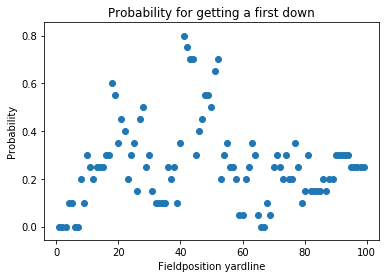

In [24]:
fig, ax = plt.subplots()
ax.scatter(data_fantasy['yrdline100'], probs)
ax.set_title('Probability for getting a first down')
ax.set(xlabel='Fieldposition yardline', ylabel='Probability')

At your own endzone it's hard to get a first down. In midfield it's way easier. But it gets harder if you come to your opponents endzone.

## What about different teams?

So let's the select additional the team in offense.

In [25]:
# Select only the columns we're interested in. 'FirstDown' is the column we want to predict.
data_with_team = data[['qtr', 'down', 'TimeSecs', 'yrdline100', 'ydstogo', 'posteam', 'FirstDown']].copy()
# Drop rows with down == NaA
data_with_team.dropna(subset=['down'], axis=0, inplace=True)
data_with_team.head()

,qtr,down,TimeSecs,yrdline100,ydstogo,posteam,FirstDown
1,1,1.0,3600.0,80.0,10,PIT,1.0
2,1,1.0,3561.0,62.0,10,PIT,0.0
3,1,2.0,3544.0,53.0,1,PIT,1.0
4,1,1.0,3506.0,49.0,10,PIT,1.0
5,1,1.0,3462.0,35.0,10,PIT,1.0


In [26]:
teams = pd.unique(data_with_team['posteam'])
models = {}
for team in teams:
    print("Processing team {}".format(team))
    mdl = RandomForestClassifier(n_estimators=20)
    data_with_single_team = data_with_team[data_with_team['posteam'] == team].copy()
    data_with_single_team.drop(columns=['posteam'], axis=1, inplace=True)
    mdl_logistic_regression_team = score_by_model(data_with_single_team, mdl)
    models[team] = mdl_logistic_regression_team

Processing team PIT
The accuracy on the training data was 0.9918330308529946.
The f1_score on the training data was 0.9919282511210762.
The accuracy on the testing data was 0.8014705882352942.
The f1_score on the testing data was 0.8169491525423729.
Processing team NE
The accuracy on the training data was 0.988666085440279.
The f1_score on the training data was 0.9886064855390009.
The accuracy on the testing data was 0.8194690265486726.
The f1_score on the testing data was 0.8282828282828283.
Processing team CHI
The accuracy on the training data was 0.9973333333333333.
The f1_score on the training data was 0.9973190348525469.
The accuracy on the testing data was 0.8504504504504504.
The f1_score on the testing data was 0.8551483420593367.
Processing team GB
The accuracy on the training data was 0.9958437240232751.
The f1_score on the training data was 0.9958298582151794.
The accuracy on the testing data was 0.8263069139966274.
The f1_score on the testing data was 0.8372827804107426.
Pro

### Show four different teams

Denver (12-4) beat Carolina (15-1) in SuperBowl 50 (https://en.wikipedia.org/wiki/2015_NFL_season)
So we compare these two teams against the two worst teams Tennessee and Cleveland (both 3-13)

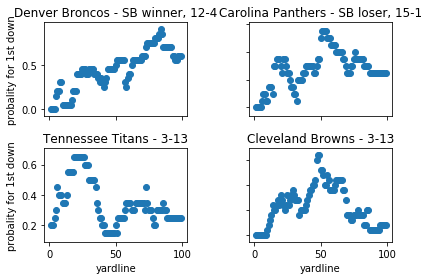

In [27]:
fig, axs = plt.subplots(2, 2)

probs = models['DEN'].predict_proba(data_fantasy)[:, 1]
axs[0,0].scatter(data_fantasy['yrdline100'], probs)
axs[0,0].set_title('Denver Broncos - SB winner, 12-4')

probs = models['CAR'].predict_proba(data_fantasy)[:, 1]
axs[0,1].scatter(data_fantasy['yrdline100'], probs)
axs[0,1].set_title('Carolina Panthers - SB loser, 15-1')

probs = models['TEN'].predict_proba(data_fantasy)[:, 1]
axs[1,0].scatter(data_fantasy['yrdline100'], probs)
axs[1,0].set_title('Tennessee Titans - 3-13')

probs = models['CLE'].predict_proba(data_fantasy)[:, 1]
axs[1,1].scatter(data_fantasy['yrdline100'], probs)
axs[1,1].set_title('Cleveland Browns - 3-13')


for ax in axs.flat:
    ax.set(xlabel='yardline', ylabel='probality for 1st down')
    
for ax in fig.get_axes():
    ax.label_outer()
    
plt.tight_layout()

As you can see both SuperBowl teams have higher probabilities than the bad teams. 

Getting first downs helps winning championships!